In [1]:
from darts.metrics import mape, smape, mse

In [2]:
from darts import TimeSeries
timeseries = TimeSeries.from_csv("Hourly_ada_utc_5Y.csv", time_col="date", fill_missing_dates=True)

In [3]:
timeseries.to_csv("test.csv")

In [4]:
import pandas as pd
df = pd.read_csv("test.csv", index_col="date", parse_dates=True)

In [5]:
last_6days_df = df[["rate"]].tail(24 * 6) # extracting the last six days
last_6days_df.shape

(144, 1)

In [6]:
train_df = last_6days_df[:24*5] # taking the first 5 days as train set
test_df = last_6days_df[24*5:] # taking the last day as test set
print(train_df.shape)
print(test_df.shape)

(120, 1)
(24, 1)


## Baseline model Linear Regression

In [7]:
from sklearn.linear_model import LinearRegression
import numpy as np

timesteps_of_train_df_starting_from_0 = np.arange(len(train_df)).reshape(-1, 1) # getting the lenght of the train set as an array to feed as X = timesteps into the regression model

model = LinearRegression().fit(timesteps_of_train_df_starting_from_0, train_df[["rate"]]) #fitting a LinearRegression model

In [8]:
slope = model.coef_[0][0]
intercept = model.intercept_[0]

In [9]:
x_values = np.linspace(0, len(last_6days_df), 100)
y_values = slope * x_values + intercept

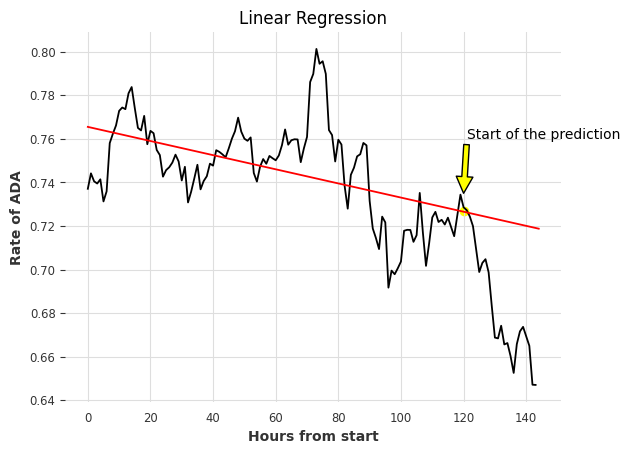

In [43]:
import matplotlib.pyplot as plt

timesteps_of_last_6days_df_starting_from_0 = np.arange(len(last_6days_df)).reshape(-1, 1)

# Plot data points and regression line
plt.plot(timesteps_of_last_6days_df_starting_from_0, last_6days_df[["rate"]])
plt.plot(x_values, y_values, color='red')
plt.scatter(120, 0.727, color='yellow', marker='o', label='start of the prediction')

plt.annotate('Start of the prediction', xy=(120, 0.735), xytext=(121, 0.76),
             arrowprops=dict(facecolor='yellow'))

plt.xlabel('Hours from start')
plt.ylabel('Rate of ADA')
plt.title('Linear Regression')
plt.show()

In [11]:
timesteps_after_x_train = np.arange(start =len(train_df), stop= len(test_df)+len(train_df)).reshape(-1, 1) # get the timesteps after train df as x test

y_pred = model.predict(timesteps_after_x_train) # predict values

y_pred = pd.DataFrame(y_pred, columns=["rate_pred"], index=test_df.index) # create df using original datetime index


In [12]:
y_test_vs_y_pred = pd.concat([test_df, y_pred],axis=1)
y_test_vs_y_pred.columns = ["rate_true", "rate_pred"]
y_test_vs_y_pred.head()


,rate_true,rate_pred
date,,
2024-03-16 09:00:00,0.728579,0.726552
2024-03-16 10:00:00,0.727272,0.726227
2024-03-16 11:00:00,0.724332,0.725902
2024-03-16 12:00:00,0.719929,0.725578
2024-03-16 13:00:00,0.709493,0.725253


<Axes: xlabel='date'>

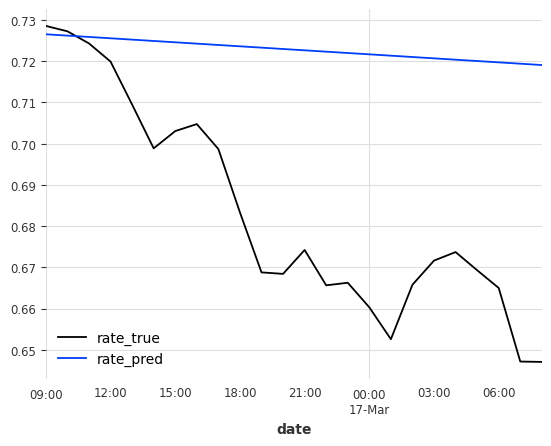

In [13]:
y_test_vs_y_pred.plot()

In [16]:
from sklearn.metrics import mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error

mse = mean_squared_error(y_test_vs_y_pred["rate_true"], y_test_vs_y_pred["rate_pred"])#, squared=False)
rmse = root_mean_squared_error(y_test_vs_y_pred["rate_true"], y_test_vs_y_pred["rate_pred"])
mape = mean_absolute_percentage_error(y_test_vs_y_pred["rate_true"], y_test_vs_y_pred["rate_pred"]) * 100
print(f"MSE: {mse:.5f}")
print(f"RMSE: {rmse:.5f}")
print(f"MAPE: {mape:.2f} %")

def smape(y_true, y_pred):
    return 100/len(y_true) * np.sum(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
smape_ = smape(y_test_vs_y_pred["rate_true"], y_test_vs_y_pred["rate_pred"])

print(f"SMAPE: {smape_:.2f} %")

linear_regression = {"MSE": mse,
                     "RMSE": rmse,
                     "MAPE": mape,
                     "SMAPE": smape_}


MSE: 0.00212
RMSE: 0.04602
MAPE: 5.98 %
SMAPE: 5.75 %


## Baseline model ARIMA

In [17]:
darts_timeseries_6days = TimeSeries.from_dataframe(last_6days_df)

In [18]:
darts_train, darts_test = darts_timeseries_6days.split_before(120)

In [19]:
from darts.models import AutoARIMA
from darts.utils.timeseries_generation import datetime_attribute_timeseries

future_cov = datetime_attribute_timeseries(darts_train, "hour", cyclic=True, add_length=24) #use some future covariates; e.g. the value of the day encoded as a sine and cosine series

arima = AutoARIMA()

arima.fit(darts_train, future_covariates=future_cov)

darts_prediction = arima.predict(24, future_covariates=future_cov)

C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsforecast\core.py:26: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsforecast\utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


<Axes: xlabel='date'>

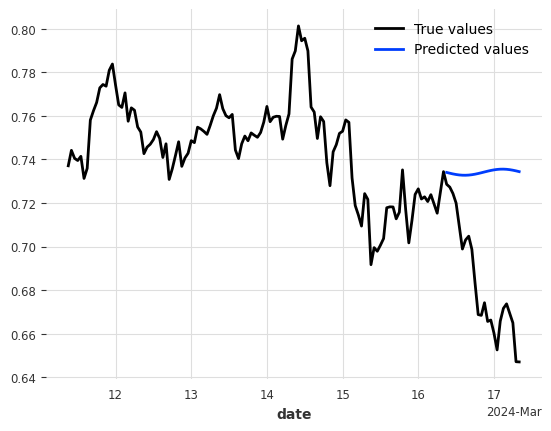

In [20]:
#darts_test.plot(label="True values")
darts_timeseries_6days.plot(label="True values")
darts_prediction.plot(label="Predicted values")

In [21]:
from darts.metrics import mape, smape, mse

mse_metric_aa = mse(darts_test, darts_prediction)
print(f"MSE: {mse_metric_aa:.5f}")
print(f"RMSE: {np.sqrt(mse_metric_aa):.5f}")
mape_arima = mape(darts_test, darts_prediction)
print(f"MAPE: {mape_arima:.2f} %")
smape_arima = smape(darts_test, darts_prediction)
print(f"SMAPE: {smape_arima:.2f} %") # for MAPE and SMAPE -> What is the mean percentage of the error?

auto_arima = {"MSE": mse_metric_aa,
                "RMSE": np.sqrt(mse_metric_aa),
                "MAPE": mape_arima,
                "SMAPE": smape_arima}

MSE: 0.00328
RMSE: 0.05727
MAPE: 7.62 %
SMAPE: 7.27 %


## Baseline Naive Moving Average

<Axes: xlabel='date'>

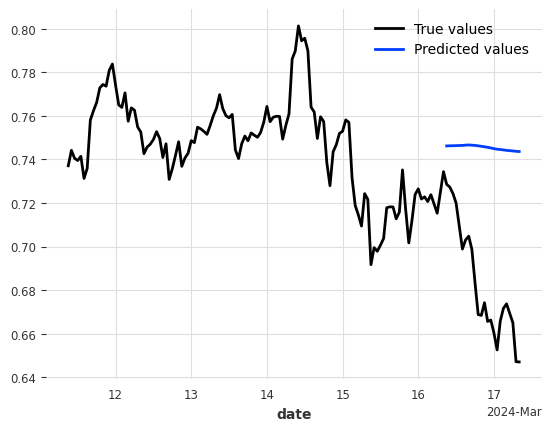

In [22]:
from darts.models import NaiveMovingAverage
naive_m_a = NaiveMovingAverage(input_chunk_length=120)

naive_m_a.fit(darts_train)

naive_m_a_pred = naive_m_a.predict(24)

darts_timeseries_6days.plot(label="True values")
naive_m_a_pred.plot(label="Predicted values")

In [25]:
mse_metric_naive_m_a = mse(darts_test, naive_m_a_pred)
print(f"MSE: {mse_metric_naive_m_a:.5f}")
print(f"RMSE: {np.sqrt(mse_metric_naive_m_a):.5f}")

mape_naive_ma = mape(darts_test, naive_m_a_pred)
print(f"MAPE: {mape_naive_ma:.2f} %")

smape_naive_ma = smape(darts_test, naive_m_a_pred)
print(f"SMAPE: {smape_naive_ma:.2f} %")

naive_moving_a = {"MSE": mse_metric_naive_m_a,
                "RMSE": np.sqrt(mse_metric_naive_m_a),
                "MAPE": mape_naive_ma,
                "SMAPE": smape_naive_ma}

MSE: 0.00449
RMSE: 0.06701
MAPE: 9.27 %
SMAPE: 8.80 %


## Baseline model Naive Seasonal + Drift

<Axes: xlabel='date'>

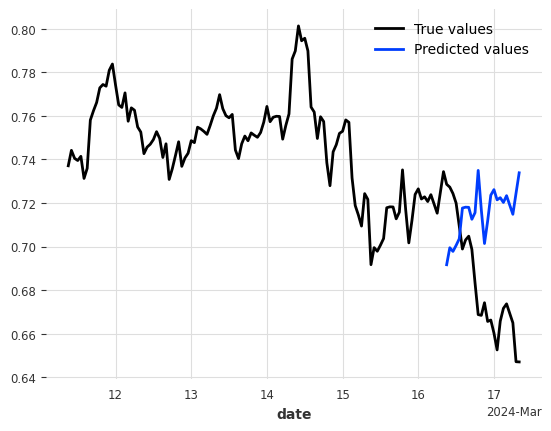

In [26]:
from darts.models import NaiveSeasonal
from darts.models import NaiveDrift

naive_model = NaiveSeasonal(K=24) # seasonality of 24 h
naive_model.fit(darts_train)
naive_seasonal_forecast = naive_model.predict(24)

drift_model = NaiveDrift() #produces linear predictions, with a slope that is determined by the first and last values of the training set
drift_model.fit(darts_train)
drift_forecast = drift_model.predict(24)

combined_forecast = drift_forecast + naive_seasonal_forecast - darts_train.last_value() #simply fit a naive drift model, and add its forecast to the seasonal forecast

darts_timeseries_6days.plot(label="True values")
#darts_test.plot(label="True values")
combined_forecast.plot(label="Predicted values")


In [28]:
mse_metric_comb = mse(darts_test, combined_forecast)
print(f"MSE: {mse_metric_comb:.5f}")
print(f"RMSE: {np.sqrt(mse_metric_comb):.5f}")
mape_comb = mape(darts_test, combined_forecast)
print(f"MAPE: {mape_comb:.2f} %")

smape_comb = smape(darts_test, combined_forecast)
print(f"SMAPE: {smape_comb:.2f} %")

combi = {"MSE": mse_metric_comb,
                "RMSE": np.sqrt(mse_metric_comb),
                "MAPE": mape_comb,
                "SMAPE": smape_comb}

MSE: 0.00224
RMSE: 0.04730
MAPE: 6.25 %
SMAPE: 6.04 %


In [38]:
metrics_summary = pd.DataFrame.from_dict([linear_regression, auto_arima, naive_moving_a, combi])
metrics_summary.index = ["Linear Regression", "Auto ARIMA", "Naive Moving Average", "Naive Seasonal & Naive Drift"]


In [39]:
metrics_summary.sort_values(by="SMAPE")

,MSE,RMSE,MAPE,SMAPE
Linear Regression,0.002118,0.046023,5.984002,5.753671
Naive Seasonal & Naive Drift,0.002237,0.047301,6.254866,6.038479
Auto ARIMA,0.003280,0.057272,7.622620,7.269975
Naive Moving Average,0.004490,0.067007,9.273786,8.797103
